## ENZYME KINETICS in Chain

by Anastasia Abashidze


Blavatnik Center for Drug Discovery
***

__As we learned how to analyse one plate, we can run the analysis for plates in chain using functions we wrote.__

## The Workflow

[Import Packages and create Output Folder](#import)

[Define Parameters](#parameters)

[Run Plates](#run_plates)   

[Create Screen Results Matrix](#results_matrix) 

[Plot all Plates](#plot_all_plates)

 ***

### Import Packages and create Output Folder
<a id="import"></a>

In [1]:
from nbdev.showdoc import *
import os
import sys
sys.path.append('..//')
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib as mpl
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context = 'notebook', style = 'white', palette = 'dark')

import simplydrug.core as sd

#### Create output folder

In [2]:
path = ('enzyme_chain_output')
if not os.path.exists(path):
    os.mkdir(path) 
    print('Output folder created')

Output folder created


### Define Parameters
<a id="parameters"></a>

In [3]:
# data set file name
data_files = ['hts_data//enzyme_kinetics_data1.xlsx','hts_data//enzyme_kinetics_data1.xlsx',
              'hts_data//enzyme_kinetics_data2.xlsx']

# path to layout
layout_path = 'hts_data//enzyme_kinetics_layout.xlsx'

#path to chemical library
chem_path = 'hts_data//compounds//example_chemicals.csv'

# which compound plates to import
chem_plates = ['ex_plate1','ex_plate1', 'ex_plate2']

# how to name the output files
names = ['ex_plate1_run1', 'ex_plate1_run2', 'ex_plate2_run1']


# define threshold
threshold = -2

# define palette and hue order so that each treatent associated with its own color, and the treatments appear in defined order 
palette = {'Sample':'Navy','Negative':'Darkred','Positive':'Darkgreen', 'Hit': 'Orange'}
hue_order = ['Sample', 'Negative', 'Positive', 'Hit']

### Run Plates
<a id="run_plates"></a>

The simplydrug functions we already know:

* __add_layout()__
* __normalize_z()__
* __hts_heatmap()__
* __sum_statistics()__
* __histogram_feature()__
* __pointplot_plate()__

In output for each plate we have one results table, one statistics table, and different plots, all strored in the output folder. At the end of analysis of each plate, we will transfer the plots and statistics to power point presentation using function create_presentation(). Finally, after each plate analysis we will clean up all plots and statistics from the output folder to prepare it to the next plate.

In such a way, the output folder will retain one ppt report and one results table for each plate.


Plate:  ex_plate1_run1


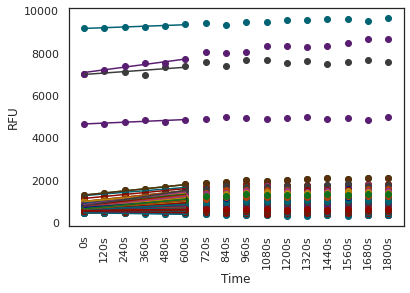

Added  Well
Added  Status
Added compounds:  ex_plate1 



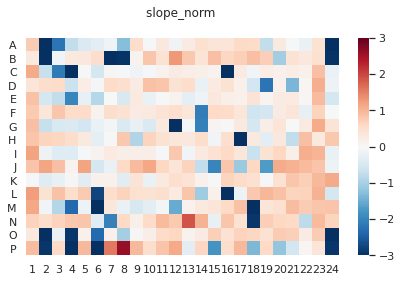

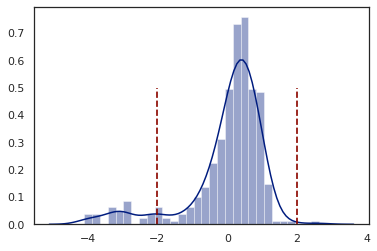

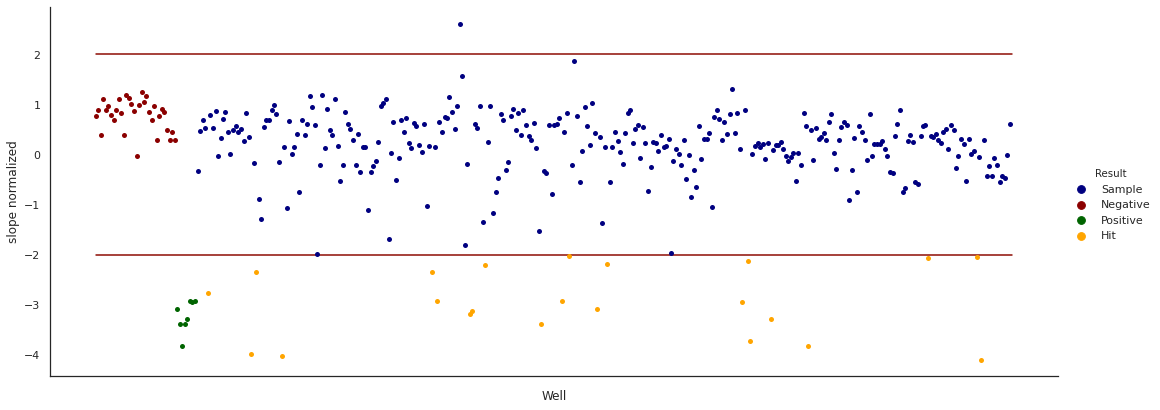

Plate:  ex_plate1_run2


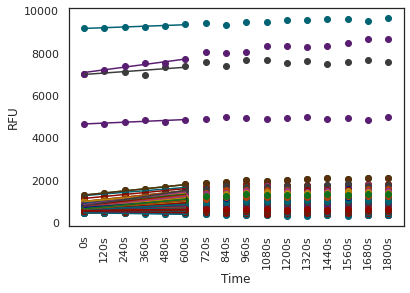

Added  Well
Added  Status
Added compounds:  ex_plate1 



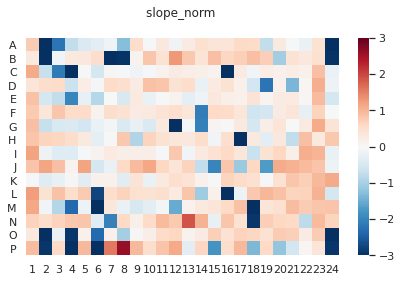

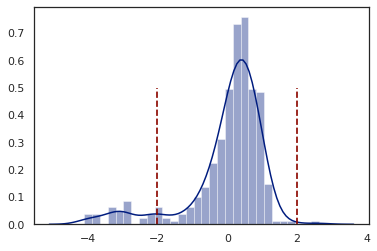

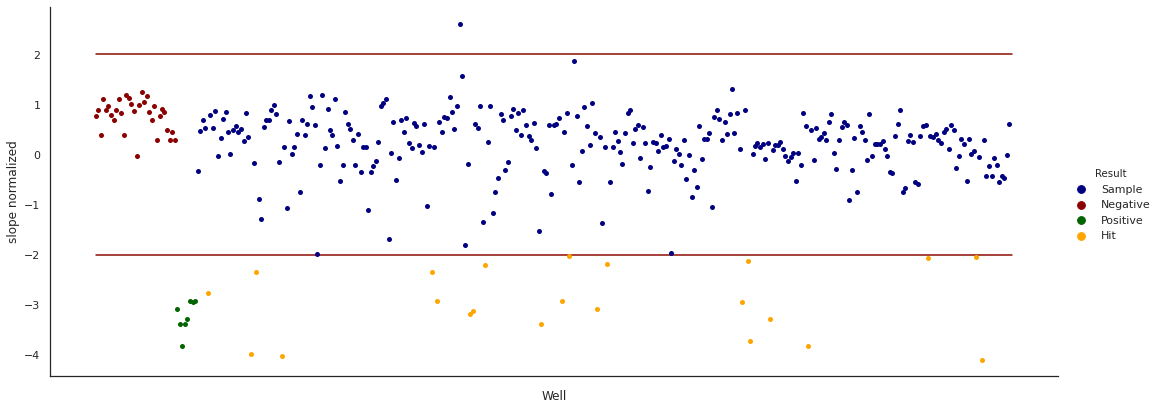

Plate:  ex_plate2_run1


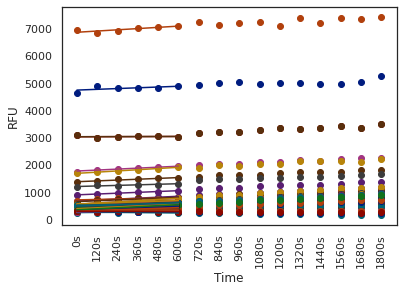

Added  Well
Added  Status
Added compounds:  ex_plate2 



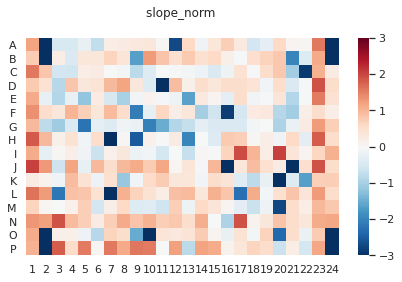

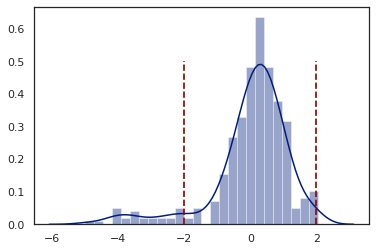

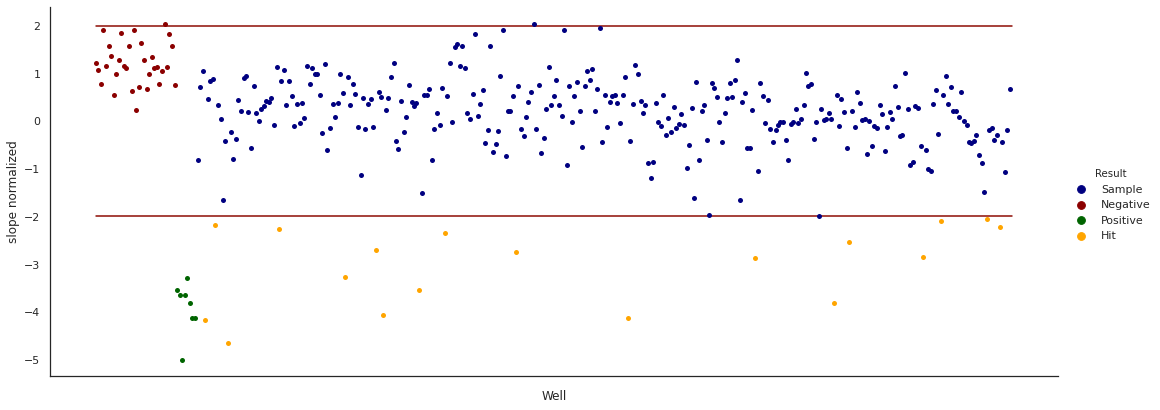

In [4]:
count = 0
for f in data_files:
    chem_plate, name = chem_plates[count], names[count]
    print('Plate: ',name)
    
    data = pd.DataFrame(pd.ExcelFile(f).parse(0)).drop_duplicates(subset = 'Well')
    slope_data = data.copy()
    slope_data.rename(columns = {'Well' : 'Time'}, inplace = True)
    slope_data = slope_data.set_index('Time').transpose()
    slope_600  = slope_data[0:6].reset_index(drop = True)
    slopes = slope_600.apply(lambda x: np.polyfit(slope_600.index, x, 1)[0])/600
    results = pd.DataFrame({'Well': data.Well.values, 'slope': slopes.values})
    
    # plot slopes
    plt.figure(figsize = (6, 4))
    for i in slope_data.columns:
        plt.scatter(slope_data.index, slope_data[i], label=i)
        plt.plot(np.polyval(np.polyfit(slope_600.index, slope_600[i], 1), slope_600.index))
    plt.xticks(rotation='vertical')
    plt.ylabel('RFU')
    plt.xlabel('Time')
    plt.savefig(path + '//' + name + '_slopes.png', bbox_inches='tight', dpi=600)
    plt.show()
    plt.close()

    # add layout and run QC
    results = sd.add_layout(results, layout_path, chem_path = chem_path, chem_plate = chem_plate).drop_duplicates(subset = ['Plate', 'Well'])
    results = sd.normalize_z(results, 'slope')
    sd.hts_heatmap(results, layout_path, ['slope_norm'], save_as = name + '_histogram.png', path = path)
    results = results[results.Status != 'Reference']
    sd.sum_statistics(results, 'slope_norm').to_csv(path + '//sum_statistics.csv', index = False) # save to output folder
    sd.histogram_feature(df = results, feature = 'slope_norm', save_as = name + '_histogram.png', path = path)
    
    # select hits
    results['Result'] = results['Status'].values
    results['Result'] = np.where((results['slope_norm'] <= threshold) & (results['Result'] =='Sample'), 'Hit', results['Result']) 
    results['Plate'] = name
    results.to_csv(path +'//' + name + '.csv', index = False)
    hits = results[results['Result'] == 'Hit']
    hits.to_csv(path +'//' + name + '_hits.csv', index = False)
    
    # pointplot
    plot_data = results[results.Status != 'Reference'].sort_values('Status')
    sd.pointplot_plate(x = 'Well', y = 'slope_norm', df = plot_data, hue = 'Result',hue_order = hue_order,
                     threshold = threshold, ylabel = 'slope normalized', palette = palette,  save_as = name + '_pointplot.png', path = path)
    
    # generate report
    report = sd.create_presentation(path).save(path +'//report_'+ name + '.ppt')

    # Clean output directory between plates
    for f in os.listdir(path):
        if 'png' in f or  'hits' in f:
            os.remove(path +'//' + f)
    os.remove(path + '//sum_statistics.csv')
    count = count+1
    

### Create Screen Results Matrix
<a id="results_matrix"></a>
Create screen table from all plates (csv files) in the output directory.

In [5]:
screen = pd.DataFrame()
for p in [f for f in os.listdir(path) if 'csv' in f]:
    screen = screen.append(pd.read_csv(path + '//' + p))
    print('Added ', p)
print(screen.shape)
display(screen.head(3))

Added  ex_plate2_run1.csv
Added  ex_plate1_run1.csv
Added  ex_plate1_run2.csv
(1080, 11)


,Well,slope,Status,Plate,Compound_id,lib_name,SMILES,Compound Name,SecName,slope_norm,Result
0,A1,0.064429,Negative,ex_plate2_run1,NaN,NaN,NaN,NaN,NaN,1.209362,Negative
1,A2,0.006476,Positive,ex_plate2_run1,NaN,NaN,NaN,NaN,NaN,-3.299722,Positive
2,A3,0.042857,Sample,ex_plate2_run1,Compound_0320,example_library,COC(=O)C1=C(C)N(C)C(=O)N(C)C1c1cccc([N+](=O)[O...,NaN,NaN,-0.469040,Sample


#### Reorder columns and clean data

In [6]:
screen = screen[['Plate', 'Well', 'Status', 'Result', 'slope', 'slope_norm', 'Compound_id','SMILES', 'Compound Name', 
                                             'SecName', ]]
screen = screen.drop_duplicates(subset = ['Plate', 'Well'])
screen = screen[screen['Result'] != 'Reference']
print(screen.shape)
display(screen.head(3))

(1080, 10)


,Plate,Well,Status,Result,slope,slope_norm,Compound_id,SMILES,Compound Name,SecName
0,ex_plate2_run1,A1,Negative,Negative,0.064429,1.209362,NaN,NaN,NaN,NaN
1,ex_plate2_run1,A2,Positive,Positive,0.006476,-3.299722,NaN,NaN,NaN,NaN
2,ex_plate2_run1,A3,Sample,Sample,0.042857,-0.469040,Compound_0320,COC(=O)C1=C(C)N(C)C(=O)N(C)C1c1cccc([N+](=O)[O...,NaN,NaN


#### Create matrix from all plates in the screen

In [7]:
# print plate names
print(screen.Plate.unique())
print(len(screen.Compound_id.unique()))

['ex_plate2_run1' 'ex_plate1_run1' 'ex_plate1_run2']
639


In [8]:
comp_matrix = pd.DataFrame(columns = ['Compound_id', 'ex_plate2_run1', 'ex_plate1_run1', 'ex_plate1_run2'])
ids = screen.Compound_id.unique()

for i in ids:
    comp = screen[screen.Compound_id == i][['Plate', 'slope_norm']].set_index('Plate').transpose().reset_index(drop = True)
    comp['Compound_id'] = i
    comp_matrix = comp_matrix.append(comp, sort = False)
print(comp_matrix.shape)
comp_matrix = comp_matrix.round(2)#.dropna(how = 'all')
display(comp_matrix )

(639, 4)


,Compound_id,ex_plate2_run1,ex_plate1_run1,ex_plate1_run2
0,NaN,NaN,NaN,NaN
0,Compound_0320,-0.47,NaN,NaN
0,Compound_0321,-0.48,NaN,NaN
0,Compound_0322,-0.22,NaN,NaN
0,Compound_0323,-0.74,NaN,NaN
...,...,...,...,...
0,Compound_0315,NaN,-1.34096,-1.34096
0,Compound_0316,NaN,0.606485,0.606485
0,Compound_0317,NaN,-1.1725,-1.1725
0,Compound_0318,NaN,-0.542865,-0.542865


In [9]:
comp_matrix = pd.merge(comp_matrix, screen[['Compound_id', 'SMILES', 'Compound Name', 'SecName' ]], how = 'left', on = 'Compound_id')
comp_matrix = comp_matrix.drop_duplicates('Compound_id')
print(comp_matrix.shape)
display(comp_matrix.head(3))

(639, 7)


,Compound_id,ex_plate2_run1,ex_plate1_run1,ex_plate1_run2,SMILES,Compound Name,SecName
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,Compound_0320,-0.47,NaN,NaN,COC(=O)C1=C(C)N(C)C(=O)N(C)C1c1cccc([N+](=O)[O...,NaN,NaN
124,Compound_0321,-0.48,NaN,NaN,c1ccc(-c2nc(C34CC5CC(CC(C5)C3)C4)co2)cc1,NaN,NaN


#### Select his
__If in any of the runs the compound performed as hit (above or below the thershold - depending on the assay) - mark it as hit.__

In [10]:
comp_matrix['Result'] = np.nan  # initialize empty 'Result' column
comp_matrix['Result'] = np.where((comp_matrix[['ex_plate2_run1', 'ex_plate1_run1', 'ex_plate1_run2']] <= -2).any(axis = 1), 'Hit', comp_matrix['Result']) 
display(comp_matrix.sort_values('Result'))

,Compound_id,ex_plate2_run1,ex_plate1_run1,ex_plate1_run2,SMILES,Compound Name,SecName,Result
748,Compound_0154,NaN,-3.82843,-3.82843,COc1ccc(CCNC(=O)c2ccccc2NC(=O)CN2CCN(C(C)=O)CC...,NaN,NaN,Hit
520,Compound_0040,NaN,-2.11874,-2.11874,CNC(C)C(=O)NC(C(=O)N1CCCC1C(=O)NC(C(=O)NCCCCCC...,BV-6,NaN,Hit
522,Compound_0041,NaN,-3.71493,-3.71493,CC(C)N(Cc1ccccc1)S(=O)(=O)c1ccc2c(c1)CCO2,NaN,NaN,Hit
1006,Compound_0283,NaN,-2.33858,-2.33858,COc1cc(OC)nc(N)n1,NaN,NaN,Hit
698,Compound_0129,NaN,-4.09366,-4.09366,CCN(Cc1ccc2c(c1)OCCO2)S(=O)(=O)c1c(C)noc1C,NaN,NaN,Hit
...,...,...,...,...,...,...,...,...
343,Compound_0541,0.89,NaN,NaN,Cc1cc2oc(=O)cc(CN3CC(C)OC(C)C3)c2cc1C,NaN,NaN,nan
344,Compound_0542,0.84,NaN,NaN,Cc1cccc(C)c1NC1=NCCCS1,ROMPUN,XYLAZINE,nan
345,Compound_0543,0.46,NaN,NaN,COC(=O)CSCC1=CS(=O)(=O)c2ccc(Cl)cc21,NaN,NaN,nan
336,Compound_0534,-0.37,NaN,NaN,CC(C)C(N)C(=O)OCCOCn1cnc2c(=O)[nH]c(N)nc21,VALTREX,VALACYCLOVIR HYDROCHLORIDE,nan


#### Save screen to csv

In [11]:
comp_matrix.to_csv(path + '//screen_results_matrix.scv', index = False)

#### Create heatmap for all hits form the screen

In [12]:
hits = comp_matrix[comp_matrix.Result == 'Hit']
print(hits.shape)

(40, 8)


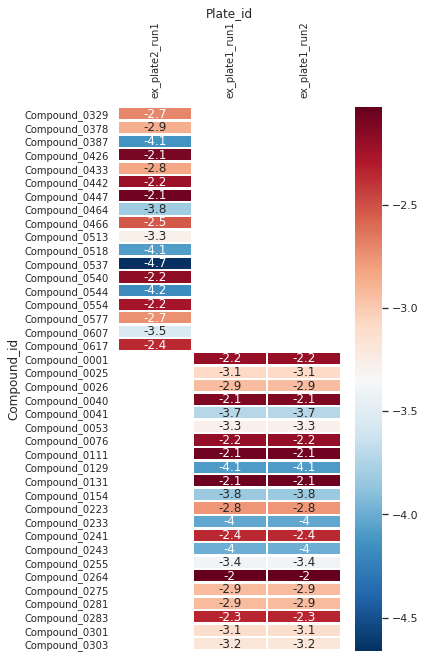

In [13]:
plot_hits = hits[['Compound_id', 'ex_plate2_run1', 'ex_plate1_run1', 'ex_plate1_run2']].set_index('Compound_id').astype(np.float64)

plt.figure(figsize = (5, 10))
ax = sns.heatmap(plot_hits, annot = True, cmap = 'RdBu_r', linewidths = 1.5)#, fmt="d", linewidths=.5, ax=ax)
plt.tick_params(axis = 'both', which = 'major', labelsize = 10, labelbottom = False, bottom = False, top = False, labeltop=True)
plt.xticks(rotation = 90)
plt.xlabel('Plate_id')
ax.xaxis.set_label_position('top')
plt.savefig(path + '//' + 'screen_hit_heatmap.png', bbox_inches = 'tight', dpi = 600)

### Plot all Plates in the Screen
<a id="plot_all_plates"></a>
__For plot, we will pick only run1 plates, and we will take only wells with compounds (samples).__

In [14]:
samples = screen[(screen.Plate != 'ex_plate1_run2') & (screen.Status == 'Sample')]
print(samples.shape)
print(samples.Plate.unique())

(640, 10)
['ex_plate2_run1' 'ex_plate1_run1']


#### Calculate grid to separate plates in the plot

In [15]:
grids = np.cumsum([len(g) for n, g in samples.groupby('Plate')])
print(grids)

[320 640]


#### Plot all plates

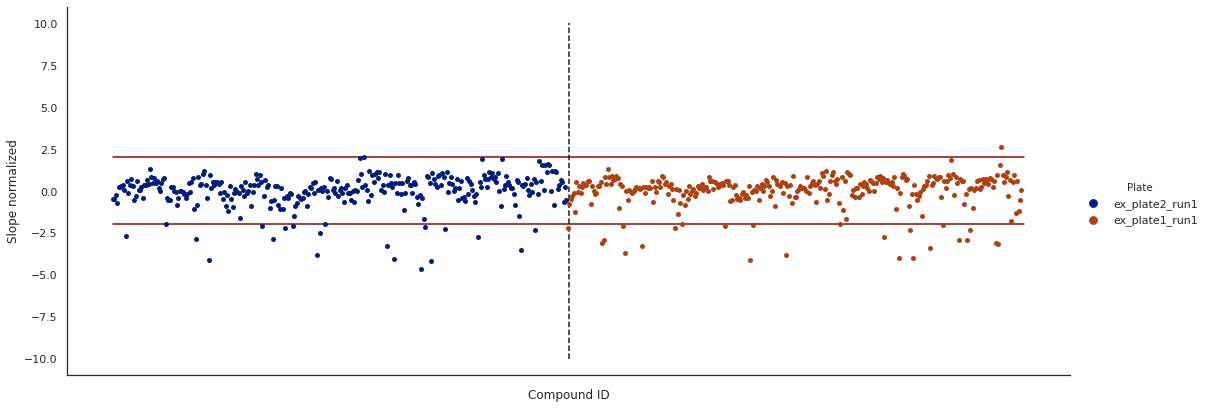

In [16]:
g = sns.catplot(x = 'Compound_id', y = 'slope_norm', hue = 'Plate', data = samples, height = 6, 
                aspect = 2.5, margin_titles = False, palette  = 'dark') #legend = False,
plt.plot([0,len(samples['Compound_id'].unique())], [-threshold, -threshold],'r-')
plt.plot([0,len(samples['Compound_id'].unique())], [threshold, threshold],'r-')
for grid in grids[0:-1]:
    plt.plot([grid,grid], [-10,10],'k--')
g.set_xticklabels([]) 
plt.xlabel('Compound ID')
plt.ylabel('Slope normalized')
g.despine()
plt.show()
g.savefig(path +'//_screen_pointplot.png', bbox_inches ='tight', dpi=600)
plt.close()

#### Save notebook as html for reporting

In [17]:
! jupyter nbconvert --to html 01b_enzyme_kinetics_chain.ipynb

[NbConvertApp] Converting notebook 01b_enzyme_kinetics_chain.ipynb to html
[NbConvertApp] Writing 680712 bytes to 01b_enzyme_kinetics_chain.html
